In [1]:
# !pip install --quiet --pre dgl-cu101
# !pip install --quiet torch==1.6.0

In [2]:
import argparse
import itertools
import os
import numpy as np
from numpy import save,load,savetxt,loadtxt,savez_compressed
from sklearn.metrics import roc_auc_score, f1_score,average_precision_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc as auc_score
import pandas as pd
import scipy.sparse as sp
import time
from tqdm import tqdm, tqdm_notebook,tnrange
tqdm.pandas(position=0, leave=True)
import math 

import torch as th
import torch.nn as nn
import torch.nn.functional as F
import dgl
import dgl.nn as dglnn
import dgl.function as fn
from dgl.ops import edge_softmax

from functools import partial
import seaborn as sns
import pickle
import random
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize']=(5.0,4.0)
plt.rcParams['image.interpolation']='nearest'
plt.rcParams['image.cmap']='gray'
import warnings
warnings.filterwarnings('ignore')
import utils
import tsne_func
print("torch version is {}".format(th.__version__))
print("DGL version is {}".format(dgl.__version__))

Using backend: pytorch


torch version is 1.6.0
DGL version is 0.6a210131


In [3]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    th.manual_seed(seed)
    th.cuda.manual_seed(seed)
    th.cuda.manual_seed_all(seed)
    th.backends.cudnn.deterministic = True
    th.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(101)

In [4]:
data_dir="/workspace/cjiang/eagle_project/CAP_graph/CAP_Update/"

start=time.time()
with open(os.path.join(data_dir,"CAP_Graph"),"rb") as f:
    G,multi_label,binary_label,\
    train_mask_multi_label,  val_mask_multi_label,  test_mask_multi_label,\
    train_mask_binary_label, val_mask_binary_label, test_mask_binary_label=pickle.load(f)
end=time.time()
print("It took {:0.4f} seconds to load graph".format(end-start))

It took 9.1880 seconds to load graph


In [5]:
utils.graph_show(G)

**************************************************
Node_types:  ['usaanr']
Edge_types:  ['AUTO_RELATED', 'Brother_Sister', 'Busi_rel_Other', 'Child', 'Ex-Spouse', 'Parent', 'Pers_rel_Other', 'SPONSEE', 'SPONSOR', 'Spouse', 'Step-Child', 'Step-Parent']
**************************************************
Canonical Etypes of Graph is:

usaanr              AUTO_RELATED        usaanr              
usaanr              Brother_Sister      usaanr              
usaanr              Busi_rel_Other      usaanr              
usaanr              Child               usaanr              
usaanr              Ex-Spouse           usaanr              
usaanr              Parent              usaanr              
usaanr              Pers_rel_Other      usaanr              
usaanr              SPONSEE             usaanr              
usaanr              SPONSOR             usaanr              
usaanr              Spouse              usaanr              
usaanr              Step-Child          usaanr          

In [6]:
usaanr_feat=[]
for key, scheme in G.node_attr_schemes(ntype="usaanr").items():
    usaanr_feat.append(key)
usaanr_feat=[x for x in usaanr_feat if x not in ['ZIPCD']]

print()
print("The features associated with USAA Member are\n ")
for i in usaanr_feat:
    print(i)


The features associated with USAA Member are
 
usaayr
AGE_BAND
ORIGEL
ELIG2
cmpyelig
SEX
MARST
BRANCH
ENLPAYGD
MILST
MLIST_OrigStat
ACTCORP
STATE
Segment


In [7]:
## USAA Members Features Embedding
class USAANR_Embedding(nn.Module):
    def __init__(self,G,feature_size):
        super(USAANR_Embedding,self).__init__()
        self.G=G.to(device)
        self.feature_size=feature_size
        ## Embedding matrices for features of nodes.
        self.emb = nn.ModuleDict()
        
        for i,col in enumerate(usaanr_feat):
            self.emb[col]=nn.Embedding(G.nodes['usaanr'].data[col].max().item()+1, feature_size)
    
    def forward(self,nid):
        nid=nid.to(device)
        extra_repr=[]
        for i,col in enumerate(usaanr_feat):
            ndata=self.G.nodes['usaanr'].data[col]
            extra_repr.append(self.emb[col](ndata[nid]).squeeze(1))
        return th.stack(extra_repr, 0).sum(0)


class RelGraphConvLayer(nn.Module):
    r"""Relational graph convolution layer.
    Parameters
    ----------
    in_feat : int
        Input feature size.
    out_feat : int
        Output feature size.
    rel_names : list[str]
        Relation names.
    num_bases : int, optional
        Number of bases. If is none, use number of relations. Default: None.
    weight : bool, optional
        True if a linear layer is applied after message passing. Default: True
    bias : bool, optional
        True if bias is added. Default: True
    activation : callable, optional
        Activation function. Default: None
    self_loop : bool, optional
        True to include self loop message. Default: False
    dropout : float, optional
        Dropout rate. Default: 0.0
    """
    def __init__(self,
                 in_feat,
                 out_feat,
                 rel_names,
                 num_bases,
                 *,
                 weight=True,
                 bias=True,
                 activation=None,
                 self_loop=False,
                 dropout=0.0):
        super(RelGraphConvLayer, self).__init__()
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.rel_names = rel_names
        self.num_bases = num_bases
        self.bias = bias
        self.activation = activation
        self.self_loop = self_loop
        self.conv = dglnn.HeteroGraphConv({
#                 rel : dglnn.GraphConv(in_feat, out_feat, norm="both", weight=False, bias=False)
                rel : dglnn.SAGEConv(in_feat, out_feat, aggregator_type='mean',feat_drop=0.,bias=True,norm=None)
                for rel in rel_names
            })
        self.use_weight = weight
        self.use_basis = num_bases < len(self.rel_names) and weight
        if self.use_weight:
            if self.use_basis:
                self.basis = dglnn.WeightBasis((in_feat, out_feat), num_bases, len(self.rel_names))
            else:
                self.weight = nn.Parameter(th.Tensor(len(self.rel_names), in_feat, out_feat))
                nn.init.xavier_uniform_(self.weight, gain=nn.init.calculate_gain('relu'))
        # bias
        if bias:
            self.h_bias = nn.Parameter(th.Tensor(out_feat))
            nn.init.zeros_(self.h_bias)
        # weight for self loop
        if self.self_loop:
            self.loop_weight = nn.Parameter(th.Tensor(in_feat, out_feat))
            nn.init.xavier_uniform_(self.loop_weight,
                                    gain=nn.init.calculate_gain('relu'))
        self.dropout = nn.Dropout(dropout)
    def forward(self, g, inputs):
        """Forward computation
        Parameters
        ----------
        g : DGLHeteroGraph
            Input graph.
        inputs : dict[str, torch.Tensor]
            Node feature for each node type.
        Returns
        -------
        dict[str, torch.Tensor]
            New node features for each node type.
        """
        g = g.local_var()
        if self.use_weight:
            weight = self.basis() if self.use_basis else self.weight
            wdict = {self.rel_names[i] : {'weight' : w.squeeze(0)}
                     for i, w in enumerate(th.split(weight, 1, dim=0))}
        else:
            wdict = {}
        if g.is_block:
            inputs_src = inputs
            inputs_dst = {k: v[:g.number_of_dst_nodes(k)] for k, v in inputs.items()}
        else:
            inputs_src = inputs_dst = inputs
        hs = self.conv(g, inputs)
        def _apply(ntype, h):
            if self.self_loop:
                h = h + th.matmul(inputs_dst[ntype], self.loop_weight)
            if self.bias:
                h = h + self.h_bias
            if self.activation:
                h = self.activation(h)
            return self.dropout(h)
        return {ntype : _apply(ntype, h) for ntype, h in hs.items()}
    

class Entity_Classify(nn.Module):
    def __init__(self,
                 g,
                 h_dim,
                 out_dim,
                 num_bases,
#                  embed_layer,
                 num_hidden_layers=1,
                 dropout=0,
                 use_self_loop=False):
        super(Entity_Classify, self).__init__()
        self.g = g
        self.h_dim = h_dim
        self.out_dim = out_dim
        self.rel_names = list(set(g.etypes))
#         self.num_bases = None if num_bases < 0 else num_bases
        if num_bases < 0 or num_bases > len(self.rel_names):
            self.num_bases = len(self.rel_names)
        else:
            self.num_bases = num_bases
            
        self.num_hidden_layers = num_hidden_layers
        self.dropout = dropout
        self.use_self_loop = use_self_loop
        
#         self.node_embed={}
        self.node_embed=nn.ModuleDict()
        self.node_embed['usaanr'] = USAANR_Embedding(self.g,self.h_dim)
#         self.node_embed['zipcode'] = Zipcode_Embedding(self.g,self.h_dim)
        self.layers = nn.ModuleList()
        #i2h
        self.layers.append(RelGraphConvLayer(
                    self.h_dim, self.h_dim, self.rel_names,
                    self.num_bases, activation=F.relu, self_loop=self.use_self_loop,
                    dropout=self.dropout, weight=True))
        # h2h
        if self.num_hidden_layers>1:
            for i in range(0,self.num_hidden_layers-1):
                self.layers.append(RelGraphConvLayer(
                    self.h_dim, self.h_dim, self.rel_names,
                    self.num_bases, activation=F.relu, self_loop=self.use_self_loop,
                    dropout=self.dropout))
        # h2o
#         self.layers.append(RelGraphConvLayer(
#             self.h_dim, self.out_dim, self.rel_names, 
#             self.num_bases, activation=partial(F.softmax, dim=1),
#             self_loop=self.use_self_loop))
        self.classifier = nn.Linear(self.h_dim, self.out_dim)
    
    def forward(self, input_nodes, blocks=None):
        H={}
        for ntype, nid in input_nodes.items():
            nid = input_nodes[ntype]
            H[ntype] = self.node_embed[ntype](nid)
        if blocks is None:
            for layer in self.layers:
                H = layer(self.g, H)
        else:
            for layer, block in zip(self.layers, blocks):
                H = layer(block, H)
        output = self.classifier(H["usaanr"])
    
        return output, H["usaanr"]

In [8]:
def lift_gain_eval(logit,label,topk):
    DF=pd.DataFrame(columns=["pred_score","actual_label"])
    DF["pred_score"]=logit
    DF["actual_label"]=label
    DF.sort_values(by="pred_score", ascending=False, inplace=True)
    gain={}
    for p in topk:
        N=math.ceil(int(DF.shape[0]*p))
        DF2=DF.nlargest(N,"pred_score",keep="first")
        gain[str(int(p*100))+"%"]=round(DF2.actual_label.sum()/(DF.actual_label.sum()*p),2)
    return gain

In [9]:
def evaluate(model, loader, labels, category, device):
    model.eval()
    total_loss = 0
    total_acc = 0
    total_precision=0
    total_recall=0
    total_fscore=0
    total_auc=0
    total_pr_auc=0
    
    total_gain={}
    for p in [0.01,0.05,0.10]:
        total_gain[str(int(p*100))+"%"]=0
        
    count = 0
    count_loss=0
    
    for input_nodes_raw, seeds_raw, blocks in tqdm(loader, position=0, leave=True):
        blocks = [blk.to(device) for blk in blocks]
        
        seeds=seeds_raw.to(device)

        input_nodes={}
        input_nodes[category]=input_nodes_raw
        input_nodes={k : e.to(device) for k, e in input_nodes.items()}

        lbl = labels[seeds].to(device)
        logits,h = model(input_nodes,blocks)
        loss = F.cross_entropy(logits, lbl.squeeze(1).to(device))
        loss = F.cross_entropy(logits, lbl.squeeze(1),weight=th.Tensor([1,args.weight]).to(device))

        acc = th.sum(logits.argmax(dim=1) == lbl.squeeze(1)).item() / logits.shape[0]
        precision, recall, fscore, support = score(lbl.squeeze(1).cpu().numpy(), logits.argmax(dim=1).cpu().numpy())

      
        auc = roc_auc_score(lbl.detach().cpu().numpy().ravel(), th.sigmoid(logits)[:,1].detach().cpu().numpy().ravel())
        prec,rec,_ = precision_recall_curve(lbl.detach().cpu().numpy().ravel(), th.sigmoid(logits)[:,1].detach().cpu().numpy().ravel())
        pr_auc=auc_score(rec,prec)
        
        total_loss += loss.item() * len(seeds) 
        total_acc += acc
        total_precision += precision[1]
        total_recall += recall[1]
        total_fscore += fscore[1]
        total_auc += auc
        total_pr_auc += pr_auc
        count += 1
        count_loss += len(seeds)
        
        arg1=logits[:,1].detach().cpu().numpy()
        arg2=lbl.cpu().numpy()
        gain = lift_gain_eval(arg1,arg2,topk=[0.01,0.05,0.10])
        for k in gain.keys():
            total_gain[k] += gain[k] 
    
    GAIN={}
    for k in total_gain.keys():
        GAIN[k]=total_gain[k]/count
    
    ACCURACY=total_acc / count
    LOSS=total_loss / count_loss
    AUC=total_auc/count
    PR_AUC=total_pr_auc/count
    PRECISION=total_precision/count
    RECALL=total_recall/count
    F1_SCORE=total_fscore/count
    
    return LOSS, ACCURACY, PRECISION, RECALL, F1_SCORE, GAIN, AUC, PR_AUC


#### create subgraph for the purpose of preliminary test

In [10]:
# dict_nodes={"usaanr":th.arange(G.num_nodes('usaanr'))[0:1000],'zipcode':th.arange(G.num_nodes('zipcode'))[0:100]}
# sg=dgl.node_subgraph(G,dict_nodes)

# G=G.node_type_subgraph(['usaanr'])
# dict_edges={}
# for etype in G.etypes:
#     dict_edges[etype]=th.arange(G.num_edges(etype))[0:5000]
# G=dgl.edge_subgraph(G,dict_edges)

# G.nodes['usaanr'].data["_ID"].numpy().shape,binary_label.shape, binary_label[G.nodes['usaanr'].data["_ID"]].shape

#### settings

In [11]:
parser = argparse.ArgumentParser(description='RGCN')
parser.add_argument("--dropout", type=float, default=0,
        help="dropout probability")
parser.add_argument("--h_dim", type=int, default=128,
        help="number of hidden units")
parser.add_argument("--out_dim", type=int, default=1,
        help="output dimension")
parser.add_argument("--gpu", type=int, default=0,
        help="gpu")
parser.add_argument("--lr", type=float, default=1e-5,
        help="learning rate")
parser.add_argument("--num_bases", type=int, default=-1,
        help="number of filter weight matrices, default: -1 [use all]")
parser.add_argument("--num_layers", type=int, default=1,
        help="number of propagation rounds")
parser.add_argument("-e", "--n_epochs", type=int, default=1,
        help="number of training epochs")
parser.add_argument("--model_path", type=str, default="/workspace/cjiang/eagle_project/CAP_graph/CAP_without_zipcode/rgcn_model_param.pt",
        help='path for save the model')
parser.add_argument("--l2norm", type=float, default=0,
        help="l2 norm coef")
parser.add_argument("--use_self_loop", default=True, action='store_true',
        help="include self feature as a special relation")
parser.add_argument("--batch-size", type=int, default=1024,
        help="Mini-batch size. If -1, use full graph training.")
parser.add_argument("--num_mini_batch", type=int, default=8,
        help="Number of minibatch.")
parser.add_argument("--fanout", type=int, default=None,
        help="Fan-out of neighbor sampling.")
parser.add_argument("--validation",  default=True,
        help="set up validation .")
parser.add_argument("--seed",  type=int,default=101,
        help="random seed for np.random.seed, torch.manual_seed and torch.cuda.manual_seed.")

parser.add_argument("--weight",  type=float,default=1,  ## number of label=0/number of label=1
        help="weight for unbalance data")
parser.add_argument("--num_worker",  type=int,default=0,  
        help="number of worker for neighbor sampling") 
    
args,unknown=parser.parse_known_args()

args.num_layers=1
args.dropout=0.2
args.lr=1e-3
args.l2norm=1e-3
args.n_epochs=1
args.num_bases=5
args.h_dim=64
args.batch_size=10240
print(args)

Namespace(batch_size=10240, dropout=0.2, fanout=None, gpu=0, h_dim=64, l2norm=0.001, lr=0.001, model_path='/workspace/cjiang/eagle_project/CAP_graph/CAP_without_zipcode/rgcn_model_param.pt', n_epochs=1, num_bases=5, num_layers=1, num_mini_batch=8, num_worker=0, out_dim=1, seed=101, use_self_loop=True, validation=True, weight=1)


In [12]:
num_rels=len(G.etypes)
# LABEL=th.tensor(binary_label[G.nodes['usaanr'].data["_ID"]]).long()
LABEL=th.tensor(binary_label).long()
labels, count=th.unique(LABEL,return_counts=True)
num_classes=labels.shape[0]
pd.DataFrame({"label_class":labels, "count":count}).style.format({'count':'{:,}'})

,label_class,count
0,0,"19,358,913"
1,1,"6,309,591"


In [13]:
# train_mask=train_mask_binary_label[G.nodes['usaanr'].data["_ID"]] 
# val_mask=val_mask_binary_label[G.nodes['usaanr'].data["_ID"]]
# test_mask=test_mask_binary_label[G.nodes['usaanr'].data["_ID"]]

train_mask=train_mask_binary_label  
val_mask=val_mask_binary_label
test_mask=test_mask_binary_label

train_idx=th.nonzero(train_mask.squeeze()).numpy()
val_idx=th.nonzero(val_mask.squeeze()).numpy()
test_idx=th.nonzero(test_mask.squeeze()).numpy()

train_idx=th.from_numpy(train_idx).squeeze(1)    
val_idx=th.from_numpy(val_idx).squeeze(1)    
test_idx=th.from_numpy(test_idx).squeeze(1)

train_label=LABEL[train_idx]
val_label=LABEL[val_idx]
test_label=LABEL[test_idx]

print('{:<15} {:<10,}'.format("Training set",train_idx.shape[0]))
print('{:<15} {:<10,}'.format("validation set",val_idx.shape[0]))
print('{:<15} {:<10,}'.format("test set",test_idx.shape[0]))

Training set    20,534,804
validation set  2,566,850 
test set        2,566,850 


In [14]:
assert train_idx.shape[0]+val_idx.shape[0]+test_idx.shape[0] == G.num_nodes('usaanr')

In [15]:
##### check cuda
device="cpu"
use_cuda=args.gpu>=0 and th.cuda.is_available()
if use_cuda:
    th.cuda.set_device(args.gpu)
    device='cuda:%d' % args.gpu
print(device)

cuda:0


In [16]:
# create model
model = Entity_Classify(G,
                       args.h_dim,
                       num_classes,
                       num_bases=args.num_bases,
                       num_hidden_layers=args.num_layers,
                       dropout=args.dropout,
                       use_self_loop=args.use_self_loop)
if use_cuda:
    model.cuda()

model.layers

ModuleList(
  (0): RelGraphConvLayer(
    (conv): HeteroGraphConv(
      (mods): ModuleDict(
        (AUTO_RELATED): SAGEConv(
          (feat_drop): Dropout(p=0.0, inplace=False)
          (fc_self): Linear(in_features=64, out_features=64, bias=True)
          (fc_neigh): Linear(in_features=64, out_features=64, bias=True)
        )
        (Brother_Sister): SAGEConv(
          (feat_drop): Dropout(p=0.0, inplace=False)
          (fc_self): Linear(in_features=64, out_features=64, bias=True)
          (fc_neigh): Linear(in_features=64, out_features=64, bias=True)
        )
        (Busi_rel_Other): SAGEConv(
          (feat_drop): Dropout(p=0.0, inplace=False)
          (fc_self): Linear(in_features=64, out_features=64, bias=True)
          (fc_neigh): Linear(in_features=64, out_features=64, bias=True)
        )
        (Child): SAGEConv(
          (feat_drop): Dropout(p=0.0, inplace=False)
          (fc_self): Linear(in_features=64, out_features=64, bias=True)
          (fc_neigh): Lin

In [17]:
optimizer = th.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2norm)

In [18]:
# train sampler
sampler = dgl.dataloading.MultiLayerNeighborSampler([args.fanout] * args.num_layers)
train_loader = dgl.dataloading.NodeDataLoader(
    G, {'usaanr': train_idx}, sampler,
    batch_size=args.batch_size, shuffle=True, num_workers=args.num_worker)
# validation sampler
# we do not use full neighbor to save computation resources
val_sampler = dgl.dataloading.MultiLayerNeighborSampler([args.fanout] * args.num_layers)
val_loader = dgl.dataloading.NodeDataLoader(
    G, {'usaanr': val_idx}, val_sampler,
    batch_size=args.batch_size, shuffle=False, num_workers=args.num_worker)

test_sampler = dgl.dataloading.MultiLayerNeighborSampler([args.fanout] * args.num_layers)
test_loader = dgl.dataloading.NodeDataLoader(
    G, {'usaanr': test_idx}, test_sampler,
    batch_size=args.batch_size, shuffle=False, num_workers=args.num_worker)

print("The number of minibatch in training set is {:,}".format(len(train_loader)))
print("The number of minibatch in validation set is {:,}".format(len(val_loader)))
print("The number of minibatch in test set is {:,}".format(len(test_loader)))

The number of minibatch in training set is 2,006
The number of minibatch in validation set is 251
The number of minibatch in test set is 251


In [19]:
print("The total # of parameter is {:,}".format(sum([p.nelement() for p in model.parameters()]) ) )

The total # of parameter is 142,590


In [20]:
param_dict={n: p.nelement() for n, p in model.named_parameters()}
for i,j in param_dict.items():
    print("{:<70}{:<15,}".format(i,j))

node_embed.usaanr.emb.usaayr.weight                                   5,440          
node_embed.usaanr.emb.AGE_BAND.weight                                 448            
node_embed.usaanr.emb.ORIGEL.weight                                   2,752          
node_embed.usaanr.emb.ELIG2.weight                                    384            
node_embed.usaanr.emb.cmpyelig.weight                                 320            
node_embed.usaanr.emb.SEX.weight                                      320            
node_embed.usaanr.emb.MARST.weight                                    640            
node_embed.usaanr.emb.BRANCH.weight                                   1,088          
node_embed.usaanr.emb.ENLPAYGD.weight                                 1,600          
node_embed.usaanr.emb.MILST.weight                                    512            
node_embed.usaanr.emb.MLIST_OrigStat.weight                           192            
node_embed.usaanr.emb.ACTCORP.weight                  

In [21]:
LOSS_EPOCH=[]
ACC_EPOCH=[]
# training loop
print("start training...")
dur = []
total_loss=0
losses=[]


# th.manual_seed(args.seed)
# th.cuda.manual_seed(args.seed)
# th.cuda.manual_seed_all(args.seed)
# np.ranom.seed(args.seed)
# random.seed(args.seed)
# th.backends.cudnn.deterministic=True

for epoch in tqdm(range(0,args.n_epochs)):
    
    model.train()
    IDX=[]
    H=[]
    LABEL_train=[]
    
    #====================================#
    #            Traning                 #
    #====================================#
    print("")
    print("========= Epoch {:} /{:}".format(epoch+1,args.n_epochs))
    print("Training...")
    t0 = time.time()
    for step, (input_nodes_raw, seeds_raw, blocks) in enumerate(train_loader):
        blocks = [blk.to(device) for blk in blocks]
        
        seeds=seeds_raw.to(device)
        
        labels_train=LABEL[seeds]       
        labels_train = labels_train.to(device)
        
        input_nodes={}
        input_nodes["usaanr"]=input_nodes_raw
        input_nodes={k : e.to(device) for k, e in input_nodes.items()}
        
        logits,h = model(input_nodes,blocks)
        optimizer.zero_grad()
        loss = F.cross_entropy(logits, labels_train.squeeze(1),weight=th.Tensor([1,args.weight]).to(device))
#         loss = F.cross_entropy(logits, labels_train.squeeze(1))
        total_loss+=loss.item()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        arg1=logits[:,1].detach().cpu().numpy()
        arg2=labels_train.cpu().numpy()
                
        train_gain = lift_gain_eval(arg1,arg2,topk=[0.01,0.05,0.10])
        train_acc = th.sum(logits.argmax(dim=1) == labels_train.squeeze(1)).item() / len(seeds)
        precision, recall, fscore, support = score(labels_train.squeeze(1).cpu().numpy(), logits.argmax(dim=1).cpu().numpy())
        train_auc = roc_auc_score(labels_train.detach().cpu().numpy().ravel(), th.sigmoid(logits)[:,1].detach().cpu().numpy().ravel())
        
        prec,rec,_ = precision_recall_curve(labels_train.detach().cpu().numpy().ravel(), th.sigmoid(logits)[:,1].detach().cpu().numpy().ravel())
        train_pr_auc=auc_score(rec,prec)

        IDX.extend(seeds.detach().cpu().numpy().tolist())
        H.extend(h.detach().cpu().numpy().tolist())
        LABEL_train.extend(LABEL[blocks[-1].dstnodes["usaanr"].data[dgl.NID].cpu().numpy()].tolist())
        
        if step%(len(train_loader)//10)==0 and not step==0:
            t1 = time.time()
            elapsed=utils.format_time(t1-t0)
            print("Batch {:} of {:} | Loss {:.3f} | Accuracy {:.1%} | Gain_top-1% {:.1f} | Gain_top-5% {:.1f} | Gain_top-10% {:.1f} | ROC_AUC {:.1%}  | PR_AUC: {:.1%} | Elapsed: {:}".\
                  format(step,len(train_loader),np.mean(losses[-10:]),train_acc, train_gain["1%"],train_gain["5%"],train_gain["10%"],train_auc,train_pr_auc,elapsed))    
            
#         LOSS_EPOCH.append(loss)


    #====================================#
    #            Validation-set          #
    #====================================#
    
    print()
    print("")
    print("Running Validation on training set")
    print("")
    
    loss_train, acc_train, prec_train, recall_train, fscore_train, train_gain, train_auc,train_pr_auc = evaluate(model, train_loader,  LABEL, "usaanr", device)
    
    t2=time.time()
    
    print("loss: {:.3f} |  accuracy: {:.2%} |  precision: {:.2%} | recall: {:.2%} | F1_score: {:.2%} | Gain_top-1%: {:.1f} | Gain_top-5%: {:.1f} | Gain_top-10%: {:.1f} | ROC_AUC: {:.1%} | PR_AUC: {:.1%} | Elapsed: {:}"\
      .format(loss_train, acc_train, prec_train, recall_train, fscore_train, train_gain["1%"],train_gain["5%"], train_gain["10%"], train_auc, train_pr_auc, utils.format_time(t2-t1)))

    
    print()
    print("")
    print("Running Validation on validation set")
    print("")
    loss_val, acc_val, prec_val, recall_val, fscore_val, val_gain, val_auc,val_pr_auc = evaluate(model, val_loader,  LABEL, "usaanr", device)
    
    t3=time.time()
    
    print("loss: {:.3f} |  accuracy: {:.2%} |  precision: {:.2%} | recall: {:.2%} | F1_score: {:.2%} | Gain_top-1%: {:.1f} | Gain_top-5%: {:.1f} | Gain_top-10%: {:.1f} | ROC_AUC: {:.1%} | PR_AUC: {:.1%} | Elapsed: {:}"\
      .format(loss_val, acc_val, prec_val, recall_val, fscore_val, val_gain["1%"],val_gain["5%"], val_gain["10%"], val_auc, val_pr_auc, utils.format_time(t3-t2)))
    
# if args.model_path is not None:
#     th.save(model.state_dict(), args.model_path)
    
#====================================#
#             Test-set               #
#====================================#
print()
print("")
print("Running Validation in Test Dataset")
print("")
model.eval()

loss_test, acc_test, prec_test, recall_test, fscore_test, test_gain, test_auc,test_pr_auc = evaluate(model, test_loader,  LABEL, "usaanr", device)

t3=time.time()
print("loss: {:.3f} |  accuracy: {:.2%} |  precision: {:.2%} | recall: {:.2%} | F1_score: {:.2%} | Gain_top-1%: {:.1f} | Gain_top-5%: {:.1f} | Gain_top-10%: {:.1f} | ROC_AUC: {:.1%} | PR_AUC: {:.1%} | Elapsed: {:}"\
      .format(loss_test, acc_test, prec_test, recall_test, fscore_test, test_gain["1%"], test_gain["5%"], test_gain["10%"], test_auc, test_pr_auc, utils.format_time(t3-t2)))

  0%|          | 0/1 [00:00<?, ?it/s]

start training...

========= Epoch 1 /1
Training...
Batch 200 of 2006 | Loss 0.082 | Accuracy 97.4% | Gain_top-1% 4.0 | Gain_top-5% 3.9 | Gain_top-10% 3.8 | ROC_AUC 96.1%  | PR_AUC: 87.7% | Elapsed: 0:01:32
Batch 400 of 2006 | Loss 0.063 | Accuracy 97.9% | Gain_top-1% 3.9 | Gain_top-5% 3.9 | Gain_top-10% 3.8 | ROC_AUC 98.2%  | PR_AUC: 93.2% | Elapsed: 0:02:37
Batch 600 of 2006 | Loss 0.057 | Accuracy 98.0% | Gain_top-1% 4.2 | Gain_top-5% 4.1 | Gain_top-10% 4.0 | ROC_AUC 99.1%  | PR_AUC: 96.3% | Elapsed: 0:03:43
Batch 800 of 2006 | Loss 0.054 | Accuracy 98.1% | Gain_top-1% 4.1 | Gain_top-5% 4.0 | Gain_top-10% 4.0 | ROC_AUC 99.3%  | PR_AUC: 97.1% | Elapsed: 0:04:53
Batch 1000 of 2006 | Loss 0.052 | Accuracy 98.2% | Gain_top-1% 4.0 | Gain_top-5% 4.0 | Gain_top-10% 4.0 | ROC_AUC 99.4%  | PR_AUC: 97.7% | Elapsed: 0:05:44
Batch 1200 of 2006 | Loss 0.052 | Accuracy 98.2% | Gain_top-1% 4.1 | Gain_top-5% 4.1 | Gain_top-10% 4.1 | ROC_AUC 99.5%  | PR_AUC: 98.1% | Elapsed: 0:06:52
Batch 1400 of 20

  0%|          | 0/2006 [00:00<?, ?it/s]



Running Validation on training set



  0%|          | 1/251 [00:00<00:29,  8.35it/s]

loss: 0.051 |  accuracy: 98.06% |  precision: 92.75% | recall: 99.90% | F1_score: 96.19% | Gain_top-1%: 4.1 | Gain_top-5%: 4.1 | Gain_top-10%: 4.1 | ROC_AUC: 99.6% | PR_AUC: 98.7% | Elapsed: 0:06:01


Running Validation on validation set



  0%|          | 1/251 [00:00<00:31,  7.87it/s]

loss: 0.051 |  accuracy: 98.06% |  precision: 92.08% | recall: 99.89% | F1_score: 95.82% | Gain_top-1%: 5.2 | Gain_top-5%: 5.2 | Gain_top-10%: 5.0 | ROC_AUC: 99.6% | PR_AUC: 98.4% | Elapsed: 0:00:57


Running Validation in Test Dataset



100%|██████████| 251/251 [00:33<00:00,  7.57it/s]

loss: 0.051 |  accuracy: 98.05% |  precision: 92.08% | recall: 99.89% | F1_score: 95.82% | Gain_top-1%: 5.2 | Gain_top-5%: 5.2 | Gain_top-10%: 5.0 | ROC_AUC: 99.6% | PR_AUC: 98.4% | Elapsed: 0:01:30


#### sparsity rate of embedding vector

In [22]:
H=np.array(H)
non_zero=np.count_nonzero(H)
total_val=np.product(H.shape)
sparsity=(total_val-non_zero)/total_val
density=non_zero/total_val
print("sparsity rate is {:.2%}".format(sparsity))
print("density rate is {:.2%}".format(density))
print("embedding vector shape is {}".format(H.shape))

sparsity rate is 64.34%
density rate is 35.66%
embedding vector shape is (20534804, 64)


In [23]:
IDX_train=np.array(IDX)
H_train=np.array(H)
LABEL_train=np.array(LABEL_train)
mask_train=np.array(['train']*len(IDX_train))

In [24]:
IDX_val=[]
H_val=[]
LABEL_val=[]
for input_nodes_raw, seeds_raw, blocks in tqdm(val_loader, position=0, leave=True):
    blocks = [blk.to(device) for blk in blocks]

    seeds=seeds_raw.to(device)
    
    input_nodes={}
    input_nodes["usaanr"]=input_nodes_raw
    input_nodes={k : e.to(device) for k, e in input_nodes.items()}
        
    model.eval()
    logits,h = model(input_nodes,blocks)
    IDX_val.extend(seeds.detach().cpu().numpy().tolist())
    H_val.extend(h.detach().cpu().numpy().tolist())
    
    LABEL_val.extend(LABEL[blocks[-1].dstnodes["usaanr"].data[dgl.NID].cpu().numpy()].tolist())
    
IDX_val=np.array(IDX_val)
H_val=np.array(H_val)
LABEL_val=np.array(LABEL_val)
mask_val=np.array(['val']*len(IDX_val))

100%|██████████| 251/251 [00:47<00:00,  5.26it/s]


In [25]:
IDX_test=[]
H_test=[]
LABEL_test=[]
for input_nodes_raw, seeds_raw, blocks in tqdm(test_loader, position=0, leave=True):
    blocks = [blk.to(device) for blk in blocks]
    
    seeds=seeds_raw.to(device)
    
    input_nodes={}
    input_nodes["usaanr"]=input_nodes_raw
    input_nodes={k : e.to(device) for k, e in input_nodes.items()}
    
    model.eval()
    logits,h = model(input_nodes,blocks)
    IDX_test.extend(seeds.detach().cpu().numpy().tolist())
    H_test.extend(h.detach().cpu().numpy().tolist())
    
    LABEL_test.extend(LABEL[blocks[-1].dstnodes["usaanr"].data[dgl.NID].cpu().numpy()].tolist())
    
IDX_test=np.array(IDX_test)
H_test=np.array(H_test)
LABEL_test=np.array(LABEL_test)
mask_test=np.array(['test']*len(IDX_test))

100%|██████████| 251/251 [00:55<00:00,  4.50it/s]


In [26]:
IDX=np.concatenate((IDX_train,IDX_val, IDX_test))
H=np.concatenate((H_train,H_val, H_test))
LABEL_ALL=np.concatenate((LABEL_train,LABEL_val, LABEL_test))
mask=np.concatenate((mask_train,mask_val, mask_test))

_idx=IDX.argsort()  #### sort the node id from 0 to max_num, so that it can be matched with LABEL
embedding_vector=H[_idx]
LABEL_ALL=LABEL_ALL[_idx]
mask=mask[_idx]

print("{:<30}{}".format("shape of embedding vector",embedding_vector.shape))

shape of embedding vector     (25668504, 64)


#### visualization of embedding vectors for different categories of USAA Members

In [27]:
# LABEL_ALL.squeeze().tolist()

In [28]:
DF=pd.DataFrame({"IDX":_idx.tolist(), "MASK":mask.tolist(), "Product":LABEL_ALL.squeeze().tolist()})
prod_map={0:"Auto=False",1:"Auto=True"}
DF['Product'] = list(map(prod_map.get, DF['Product']))
DF["IDX"]=np.arange(DF.shape[0])

N=2500

train_df=DF[DF["MASK"]=="train"]
sample_df_train=train_df.groupby(['Product'], group_keys=False).apply(lambda x: x.sample(n=N,random_state=101))
sample_id_train=sample_df_train["IDX"].values
prod_sample_train=DF["Product"].values[sample_id_train]
embedding_sample_train=embedding_vector[sample_id_train]

val_df=DF[DF["MASK"]=="val"]
sample_df_val=val_df.groupby(['Product'], group_keys=False).apply(lambda x: x.sample(n=N,random_state=101))
sample_id_val=sample_df_val["IDX"].values
prod_sample_val=DF["Product"].values[sample_id_val]
embedding_sample_val=embedding_vector[sample_id_val]

test_df=DF[DF["MASK"]=="test"]
sample_df_test=test_df.groupby(['Product'], group_keys=False).apply(lambda x: x.sample(n=N,random_state=101))
sample_id_test=sample_df_test["IDX"].values
prod_sample_test=DF["Product"].values[sample_id_test]
embedding_sample_test=embedding_vector[sample_id_test]

In [29]:
%%time
print("t-SNE dimension reduction for training embedding vector:")
print()
train_embedding = tsne_func.fit(embedding_sample_train)

t-SNE dimension reduction for training embedding vector:

[t-SNE] Iteration 100: error = 2.4116568, gradient norm = 0.0007143
[t-SNE] Iteration 200: error = 2.1430225, gradient norm = 0.0002642
[t-SNE] Iteration 300: error = 2.0375760, gradient norm = 0.0001647
[t-SNE] Iteration 400: error = 1.9678006, gradient norm = 0.0001304
[t-SNE] Iteration 500: error = 1.9343582, gradient norm = 0.0000942
[t-SNE] Iteration 600: error = 1.9091476, gradient norm = 0.0000851
[t-SNE] Iteration 700: error = 1.8913200, gradient norm = 0.0000723
[t-SNE] Iteration 800: error = 1.8783195, gradient norm = 0.0000643
[t-SNE] Iteration 900: error = 1.8677374, gradient norm = 0.0000509
[t-SNE] Iteration 1000: error = 1.8591300, gradient norm = 0.0000528
CPU times: user 10h 5min 34s, sys: 49min 59s, total: 10h 55min 34s
Wall time: 16min 56s


In [30]:
a,b=np.unique(prod_sample_train,return_counts=True)
pd.DataFrame({"product":a,"sampled_#":b}).style.format({'sampled_#':'{:,}'})

,product,sampled_#
0,Auto=False,"2,500"
1,Auto=True,"2,500"


Text(0.5, 1.0, 'Embedding Vectors t-SNE(sample=2500) \n Training Set ')

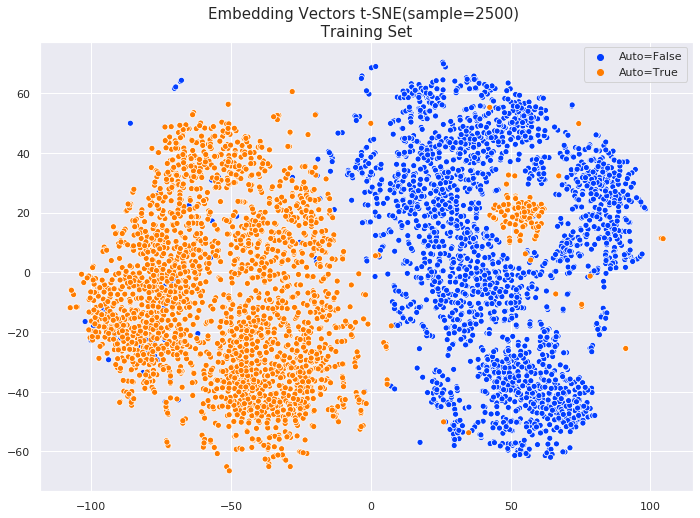

In [31]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 2)
ax=sns.scatterplot(train_embedding[:,0], train_embedding[:,1], hue=prod_sample_train.squeeze(), legend='full', palette=palette)
ax.set_title("Embedding Vectors t-SNE(sample=2500) \n Training Set ",fontsize=15)

In [32]:
%%time
print("t-SNE dimension reduction for validation embedding:")
print()
val_embedding = tsne_func.fit(embedding_sample_val)

t-SNE dimension reduction for validation embedding:

[t-SNE] Iteration 100: error = 1.6758193, gradient norm = 0.0006619
[t-SNE] Iteration 200: error = 1.3693757, gradient norm = 0.0002653
[t-SNE] Iteration 300: error = 1.2626242, gradient norm = 0.0001416
[t-SNE] Iteration 400: error = 1.2073545, gradient norm = 0.0000959
[t-SNE] Iteration 500: error = 1.1734333, gradient norm = 0.0000963
[t-SNE] Iteration 600: error = 1.1522657, gradient norm = 0.0000585
[t-SNE] Iteration 700: error = 1.1367234, gradient norm = 0.0000506
[t-SNE] Iteration 800: error = 1.1246781, gradient norm = 0.0000441
[t-SNE] Iteration 900: error = 1.1149178, gradient norm = 0.0000376
[t-SNE] Iteration 1000: error = 1.1070578, gradient norm = 0.0000337
CPU times: user 10h 5min 55s, sys: 52min 18s, total: 10h 58min 14s
Wall time: 16min 57s


In [33]:
a,b=np.unique(prod_sample_val,return_counts=True)
pd.DataFrame({"product":a,"sampled_#":b}).style.format({'sampled_#':'{:,}'})

,product,sampled_#
0,Auto=False,"2,500"
1,Auto=True,"2,500"


Text(0.5, 1.0, 'Embedding Vectors t-SNE (sample=2500) \n Validation Set ')

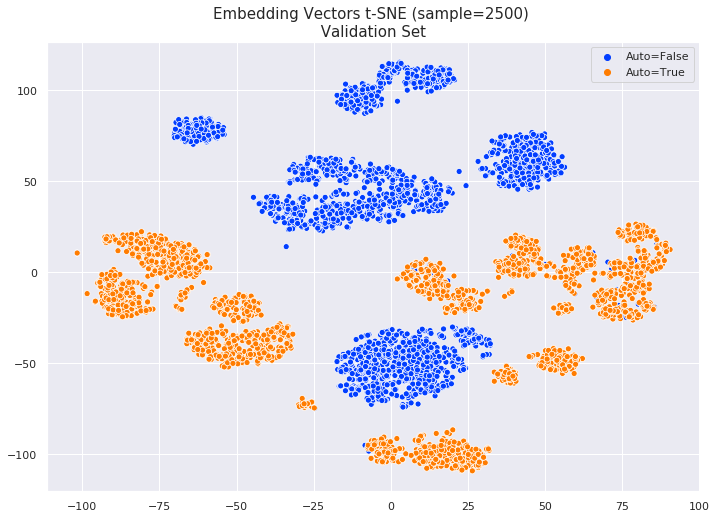

In [34]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 2)
ax=sns.scatterplot(val_embedding[:,0], val_embedding[:,1], hue=prod_sample_val.squeeze(), legend='full', palette=palette)
ax.set_title("Embedding Vectors t-SNE (sample=2500) \n Validation Set ",fontsize=15)

In [35]:
%%time
print("t-SNE dimension reduction for test embedding:")
print()
test_embedding = tsne_func.fit(embedding_sample_test)

t-SNE dimension reduction for test embedding:

[t-SNE] Iteration 100: error = 1.7177083, gradient norm = 0.0006521
[t-SNE] Iteration 200: error = 1.4131310, gradient norm = 0.0002882
[t-SNE] Iteration 300: error = 1.3066895, gradient norm = 0.0001386
[t-SNE] Iteration 400: error = 1.2512649, gradient norm = 0.0001032
[t-SNE] Iteration 500: error = 1.2106388, gradient norm = 0.0001117
[t-SNE] Iteration 600: error = 1.1825631, gradient norm = 0.0000815
[t-SNE] Iteration 700: error = 1.1662240, gradient norm = 0.0000563
[t-SNE] Iteration 800: error = 1.1500421, gradient norm = 0.0000547
[t-SNE] Iteration 900: error = 1.1364104, gradient norm = 0.0000411
[t-SNE] Iteration 1000: error = 1.1270623, gradient norm = 0.0000405
CPU times: user 10h 6min 8s, sys: 51min 31s, total: 10h 57min 39s
Wall time: 16min 56s


In [36]:
a,b=np.unique(prod_sample_test,return_counts=True)
pd.DataFrame({"product":a,"sampled_#":b}).style.format({'sampled_#':'{:,}'})

,product,sampled_#
0,Auto=False,"2,500"
1,Auto=True,"2,500"


Text(0.5, 1.0, 'Embedding Vectors t-SNE (sample=2500) \n Test Set ')

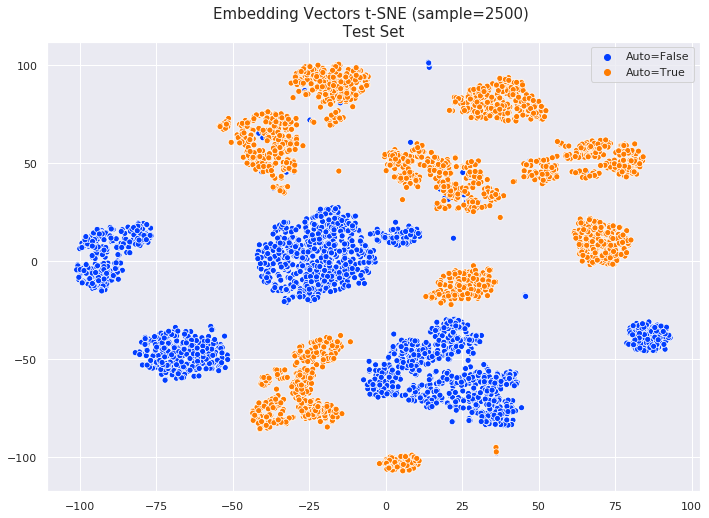

In [37]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 2)
ax=sns.scatterplot(test_embedding[:,0], test_embedding[:,1], hue=prod_sample_test.squeeze(), legend='full', palette=palette)
ax.set_title("Embedding Vectors t-SNE (sample=2500) \n Test Set ",fontsize=15)

#### score the customers in different STATE
potential customers are defined as the customers who have the following conditions:
* currently no Auto policy
* predicted scores are greater than the 90% quantile of the predicted score of existing customers who had owned Auto policy

In [38]:
### score all the data
IDX=np.concatenate((IDX_train,IDX_val, IDX_test))
H=np.concatenate((H_train,H_val, H_test))
LABEL_ALL=np.concatenate((LABEL_train,LABEL_val, LABEL_test))
Score=nn.Linear(H.shape[1], num_classes)(th.from_numpy(H).float()).detach().numpy()
score_df=pd.DataFrame({"usaanr":IDX.tolist(),"logit":Score[:,1].tolist(),"label":LABEL_ALL.squeeze().tolist()})
score_df.sort_values(by=['usaanr'],inplace=True)
score_df.head(2)

,usaanr,logit,label
15233060,0,-0.399908,1
11332490,1,1.329809,0


In [39]:
state_data=pd.read_pickle(os.path.join(data_dir,'State_Data_pickle'))
state_data.drop_duplicates(inplace=True)

In [40]:
state_list={}
state_list['32)NO CAROLINA']="NC"
state_list['46)WASHINGTON']="WA"
state_list['10)GEORGIA']="GA"
state_list['09)FLORIDA']="FL"
state_list['48)WISCONSIN']="WI"
state_list['04)CALIFORNIA']="CA"
state_list['42)TEXAS']="TX"
state_list['19)MARYLAND']="MD"
state_list['39)SO CAROLINA']="SC"
state_list['17)LOUISIANA']="LA"
state_list['47)WEST VIRGINIA']="WV"
state_list['31)NEW YORK']="NY"
state_list['41)TENNESSEE']="TN"
state_list['03)ARKANSAS']="AR"
state_list['02)ARIZONA']="AZ"
state_list['36)OREGON']="OR"
state_list['43)UTAH']="UT"
state_list['23)MISSISSIPPI']="MS"
state_list['45)VIRGINIA']="VA"
state_list['34)OHIO']="OH"
state_list['26)NEBRASKA']="NE"
state_list['16)KENTUCKY']="KY"
state_list['07)DELAWARE']="DE"
state_list['15)KANSAS']="KS"
state_list['33)NORTH DAKOTA']="ND"
state_list['05)COLORADO']="CO"
state_list['01)ALABAMA']="AL"
state_list['21)MICHIGAN']="MI"
state_list['12)ILLINOIS']="IL"
state_list['37)PENNSYLVANIA']="PA"
state_list['14)IOWA']="IA"
state_list['27)NEVADA']="NV"
state_list['24)MISSOURI']="MO"
state_list['22)MINNESOTA']="MN"
state_list['13)INDIANA']= "IN"
state_list['30)NEW MEXICO']="NM"
state_list['25)MONTANA']= 'MT'
state_list['08)DIST/COLUMBIA']= "DC"
state_list['54)ALASKA']= "AK"
state_list['703)GUAM']='703)GUAM'
state_list['35)OKLAHOMA']= "OK"
state_list['52)HAWAII']= "HI"
state_list['40)SOUTH DAKOTA']= "SD"
state_list['49)WYOMING']="WY"
state_list['11)IDAHO']= "ID"
state_list['706)NO MARIANA ISLANDS']='706)NO MARIANA ISLANDS'
state_list['721)PALAU']='721)PALAU'
state_list['44)VERMONT']="VT"
state_list['711)AMERICAN SAMOA']='711)AMERICAN SAMOA'
state_list['702)FEDERATED STATES OF MICRONESIA']='702)FEDERATED STATES OF MICRONESIA'
state_list['312)U.S. VIRGIN ISLANDS']= '312)U.S. VIRGIN ISLANDS'
state_list['707)MARSHALL ISLANDS']='707)MARSHALL ISLANDS'
state_list['29)NEW JERSEY']= "NJ"
state_list['06)CONNECTICUT']= "CT"
state_list['263)JALISCO']='263)JALISCO'
state_list['38)RHODE ISLAND']="RI"
state_list['20)MASSACHUSETTS']="MA"
state_list['28)NEW HAMPSHIRE']="NH"
state_list['272)QUINTANA ROO']='272)QUINTANA ROO'
state_list['18)MAINE']='ME'
state_list['310)PUERTO RICO']='310)PUERTO RICO'

state_data["STATE"]=state_data["STATE"].map(state_list)
state_data.sort_values(by=['usaanr'],inplace=True)
state_data["STATE"].unique()

array(['NC', 'WA', 'GA', 'FL', 'WI', 'CA', 'TX', 'MD', 'SC', 'LA', 'WV',
       'TN', 'AR', 'AZ', 'OR', 'MS', 'OH', 'VA', 'NE', 'KY', 'NY', 'DE',
       'KS', 'ND', 'AL', 'CO', 'MI', 'UT', 'IL', 'NV', 'MO', 'MN', 'IA',
       'IN', 'NM', 'MT', 'PA', 'HI', 'AK', '703)GUAM', 'OK', 'ID', 'WY',
       'DC', 'SD', nan, '706)NO MARIANA ISLANDS', '711)AMERICAN SAMOA',
       '702)FEDERATED STATES OF MICRONESIA', '721)PALAU', 'VT',
       '312)U.S. VIRGIN ISLANDS', '707)MARSHALL ISLANDS', 'CT', 'NJ',
       '263)JALISCO', '272)QUINTANA ROO', 'MA'], dtype=object)

In [41]:
print(score_df.shape)
print(state_data.shape)

(25668504, 3)
(25668504, 2)


In [42]:
state_data.head(2)

,usaanr,STATE
0,0,NC
1,1,WA


In [43]:
score_df=score_df.merge(state_data, on="usaanr",how="inner")
score_df.reset_index(drop=True,inplace=True)
print(score_df.shape)

(25668504, 4)


In [44]:
score_df.head(5)

,usaanr,logit,label,STATE
0,0,-0.399908,1,NC
1,1,1.329809,0,WA
2,2,-0.162973,1,GA
3,3,-4.758953,1,WA
4,4,2.354071,0,FL


In [45]:
def product_score(score_df, state, p):

    #### no product
    prod_v0=score_df[(score_df['label']==0) & (score_df['STATE']==state)]
    #### with product
    prod_v1=score_df[(score_df['label']==1) & (score_df['STATE']==state)]
    
    #### Determine the threshold value of score for the member who has owned product in each state
    threshold_value=np.percentile(prod_v1["logit"].values,p)
    
    output=prod_v0[prod_v0["logit"]>=threshold_value]
       
    num0=prod_v0.shape[0]
    
    num1=output.shape[0]
    
    Ratio=num1/num0
    
    return output, num1, num0, Ratio

In [54]:
%%time
output_TX, num1_TX, num0_TX, Ratio_TX=product_score(score_df, state="TX", p=99)
output_AZ, num1_AZ, num0_AZ, Ratio_AZ=product_score(score_df, state="AZ", p=99)
output_GA, num1_GA, num0_GA, Ratio_GA=product_score(score_df, state="GA", p=99)
output_FL, num1_FL, num0_FL, Ratio_FL=product_score(score_df, state="FL", p=99)
output_IL, num1_IL, num0_IL, Ratio_IL=product_score(score_df, state="IL", p=99)
output_MD, num1_MD, num0_MD, Ratio_MD=product_score(score_df, state="MD", p=99)
output_CA, num1_CA, num0_CA, Ratio_CA=product_score(score_df, state="CA", p=99)
output_VA, num1_VA, num0_VA, Ratio_VA=product_score(score_df, state="VA", p=99)
output_OR, num1_OR, num0_OR, Ratio_OR=product_score(score_df, state="OR", p=99)
output_OH, num1_OH, num0_OH, Ratio_OH=product_score(score_df, state="OH", p=99)

CPU times: user 3min 35s, sys: 17.8 s, total: 3min 53s
Wall time: 50.8 s


In [55]:
output_table={}
output_table["Total Members without Auto"]=[num0_TX,num0_AZ,num0_GA,num0_FL,num0_IL,num0_MD,num0_CA,num0_VA,num0_OR,num0_OH]
output_table["Potential Members"]= [num1_TX,num1_AZ,num1_GA,num1_FL,num1_IL,num1_MD,num1_CA,num1_VA,num1_OR,num1_OH]
output_table["Ratio of Potential Members"]= [Ratio_TX,Ratio_AZ,Ratio_GA,Ratio_FL,Ratio_IL,Ratio_MD,Ratio_CA,Ratio_VA,Ratio_OR,Ratio_OH]
tempt=pd.DataFrame(output_table)
tempt.index=["Texas","Arizona","Georgia","Florida","Illinois","Maryland","California","Virginia","Oregon","Ohio"]
tempt.style.format({"Total Members without Auto":"{:,}","Potential Members":"{:,}","Ratio of Potential Members":"{:.2%}"})

,Total Members without Auto,Potential Members,Ratio of Potential Members
Texas,"2,418,028","119,052",4.92%
Arizona,"605,053","57,248",9.46%
Georgia,"1,003,330","64,336",6.41%
Florida,"1,854,457","52,646",2.84%
Illinois,"407,457","37,671",9.25%
Maryland,"508,234","16,633",3.27%
California,"1,729,906","57,455",3.32%
Virginia,"982,864","124,650",12.68%
Oregon,"296,249","13,184",4.45%
Ohio,"495,738","24,269",4.90%


In [56]:
output_df=pd.DataFrame(columns=["usaanr","STATE"])
output_df=output_df.append(output_TX.loc[:,["usaanr","STATE"]],ignore_index=True)
output_df=output_df.append(output_AZ.loc[:,["usaanr","STATE"]],ignore_index=True)
output_df=output_df.append(output_GA.loc[:,["usaanr","STATE"]],ignore_index=True)
output_df=output_df.append(output_FL.loc[:,["usaanr","STATE"]],ignore_index=True)
output_df=output_df.append(output_IL.loc[:,["usaanr","STATE"]],ignore_index=True)
output_df=output_df.append(output_MD.loc[:,["usaanr","STATE"]],ignore_index=True)
output_df=output_df.append(output_CA.loc[:,["usaanr","STATE"]],ignore_index=True)
output_df=output_df.append(output_VA.loc[:,["usaanr","STATE"]],ignore_index=True)
output_df=output_df.append(output_OR.loc[:,["usaanr","STATE"]],ignore_index=True)
output_df=output_df.append(output_OH.loc[:,["usaanr","STATE"]],ignore_index=True)
output_df["STATE"].value_counts(dropna=False)

VA    124650
TX    119052
GA     64336
CA     57455
AZ     57248
FL     52646
IL     37671
OH     24269
MD     16633
OR     13184
Name: STATE, dtype: int64

In [57]:
# output_df.to_csv("Potential_Auto.csv.bz2",sep="\t",compression="bz2",index=False)
# output_df=pd.read_csv("./Potential_Auto.csv.bz2",sep="\t",compression="bz2")

print("The number of total potential members is {:,}".format(output_df.shape[0]))

The number of total potential members is 567,144
